In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# Part 1: logins
This exercise involves an examination of logins by viewing activity through different time frames.

In [2]:
logins_df = pd.read_json('./logins.json')
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


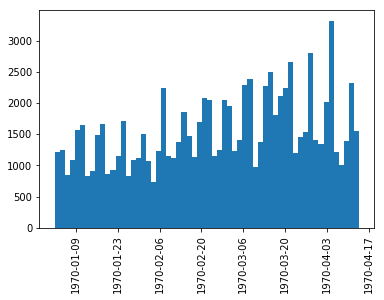

In [4]:
plt.hist(logins_df.login_time, bins=60)
plt.xticks(rotation=90)
plt.show()

In [5]:
logins_df.tail()

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


In [6]:
logins15_df = logins_df.copy(deep=True)
logins15_df['login'] = pd.to_datetime(logins15_df['login_time'])
logins15_df.set_index('login', inplace=True)
logins15_df = logins15_df.resample('15min', label='left').count()
logins15_df.columns = ['count']

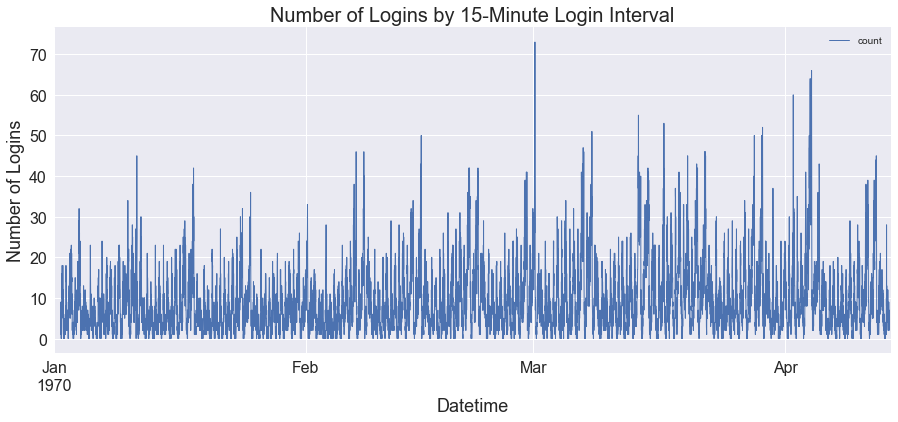

In [7]:
sns.set()
logins15_df.plot(figsize=(15,6), fontsize=16, linewidth=1)
plt.xlabel('Datetime', fontsize=18)
plt.xlim(['1970-01', '1970-04-14'])
plt.ylabel('Number of Logins', fontsize=18)
plt.title('Number of Logins by 15-Minute Login Interval', fontsize=20)
plt.show()

Looking at each 15-minute batch it is difficult to see fine resolution, but a cyclical appearance seems evident.

In [8]:
loginsD_df = logins_df.copy(deep=True)
loginsD_df['login'] = pd.to_datetime(loginsD_df['login_time'])
loginsD_df.set_index('login', inplace=True)
loginsD_df = loginsD_df.resample('D', label='left').count()
loginsD_df.columns = ['count']

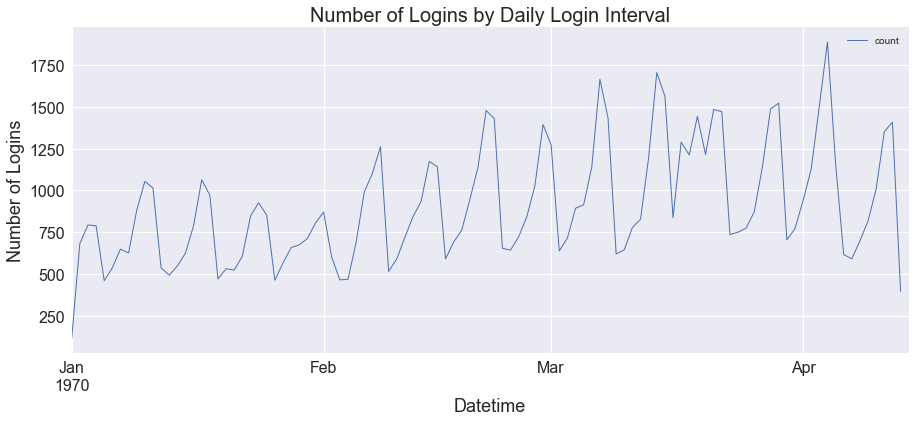

In [9]:
sns.set()
loginsD_df.plot(figsize=(15,6), fontsize=16, linewidth=1)
plt.xlabel('Datetime', fontsize=18)
plt.xlim(['1970-01', '1970-04-14'])
plt.ylabel('Number of Logins', fontsize=18)
plt.title('Number of Logins by Daily Login Interval', fontsize=20)
plt.show()

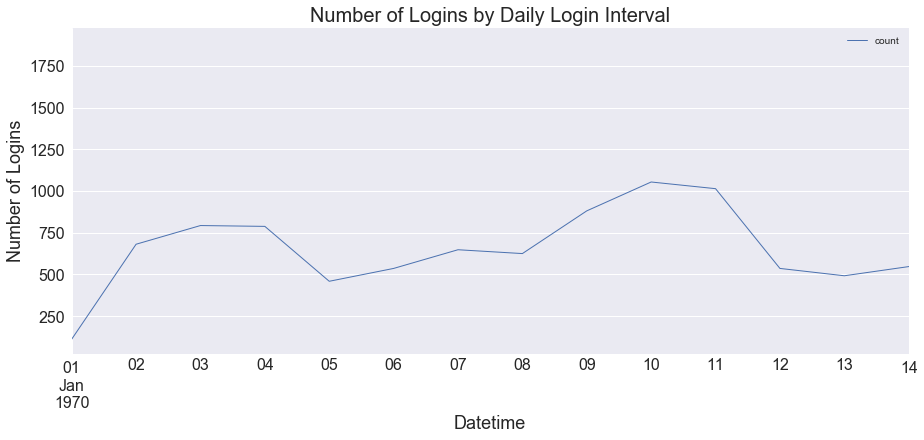

In [10]:
loginsD_df.plot(figsize=(15,6), fontsize=16, linewidth=1)
plt.xlabel('Datetime', fontsize=18)
plt.xlim(['1970-01-01', '1970-01-14'])
plt.ylabel('Number of Logins', fontsize=18)
plt.title('Number of Logins by Daily Login Interval', fontsize=20)
plt.show()

Looking on a daily basis there seemed to be a spike about every week before a sharp downturn. January 1, 1970, was a Thursday, and the peak for the week beginning that day hovers around the Saturday and Sunday of January 3-4 before a drop heading into Monday, January 5. The same pattern appears the next week. For some weeks this pattern deviated a little, but it was present for many. This suggests something about the service is either not useful equally on each day of the week, or there is a technical issue that occurs on a weekly basis that the service slowly recovers from in terms of interaction with consumers. It appears to be a pattern for which the weekends showed the times of greatest login activity. This is intriguing, though, as 1970 was a very long time ago; what were people logging into in 1970? Computer-related logins I would expect to be more restricted to the government/military at that time. That sort of activity would be unlikely to be highest on the weekends. A business that has most of its activity when people are at home could also fit the pattern, though I do not know how many businesses were set up for a login-type structure at that time. The public would be making more use of home consumer devices perhaps during the weekends, and what was around at that time I would suspect related to television, radio, or telephone. Cable television also existed back then (for a long time at that point), and perhaps there was some signal returned to the cable company when people turned on their devices or changed channels, though I am not sure if such signals were transmitted. Ratings devices could also be a source of logins, however, I believe Nielsen did not begin using "people meters" for ratings until the 1980s, relying on diaries prior to that point.

In [11]:
loginsG_df = logins_df.copy(deep=True)
loginsG_df.set_index('login_time', inplace=True)
loginsG_df['count'] = 1

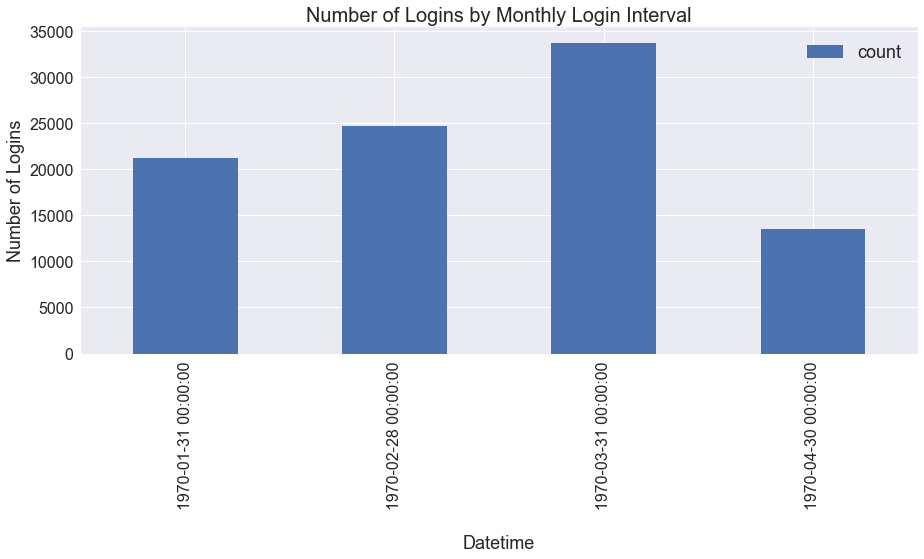

In [12]:
loginsG_df.groupby(pd.Grouper(freq='M')).count().plot(kind='bar',figsize=(15,6), fontsize=16)
plt.xlabel('\nDatetime', fontsize=18)
plt.xticks(rotation=90)
plt.ylabel('Number of Logins', fontsize=18)
plt.legend(fontsize=18)
plt.title('Number of Logins by Monthly Login Interval', fontsize=20)
plt.show()

Overall volume of logins picked up from the start of January through March. The month of April showed a precipitous drop, though this is likely at least partially reflective of the dataset terminating on April 13, 1970.

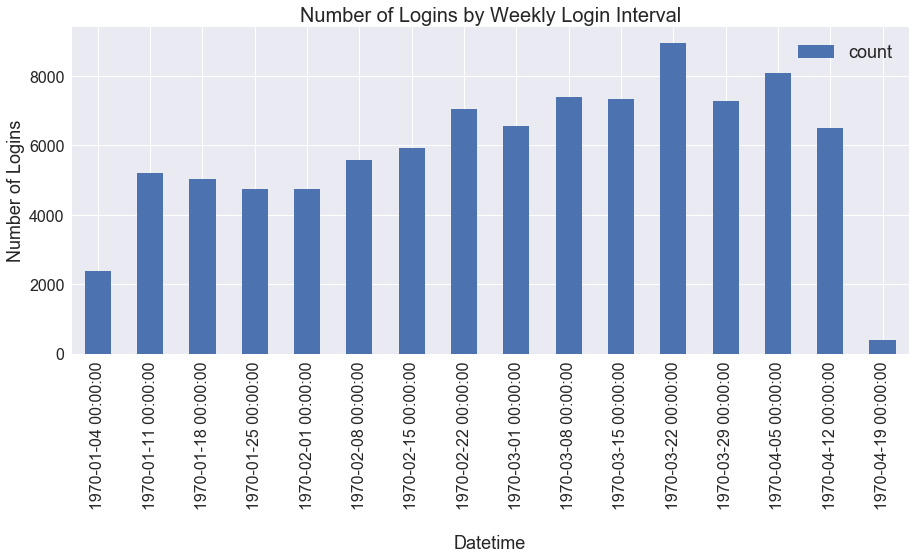

In [13]:
loginsG_df.groupby(pd.Grouper(freq='W')).count().plot(kind='bar',figsize=(15,6), fontsize=16)
plt.xlabel('\nDatetime', fontsize=18)
plt.xticks(rotation=90)
plt.ylabel('Number of Logins', fontsize=18)
plt.legend(fontsize=18)
plt.title('Number of Logins by Weekly Login Interval', fontsize=20)
plt.show()

Mid- to late-March had the highest login volume. The first week of April was similar to preceding weeks and showed more logins than the last week of March did. The second week of April showed a slight drop, still getting the bulk of the volume of weeks leading up to it, but back down on par with the last week of February (into March 1). This was enough of a drop that it should have drawn some concern. The final day of data presented in this plot was April 13, 1970, so the final bar is very low. It is possible, however, that the signals were trending downward at this time anyway, though without knowing what the logins related to, it is difficult to tell.

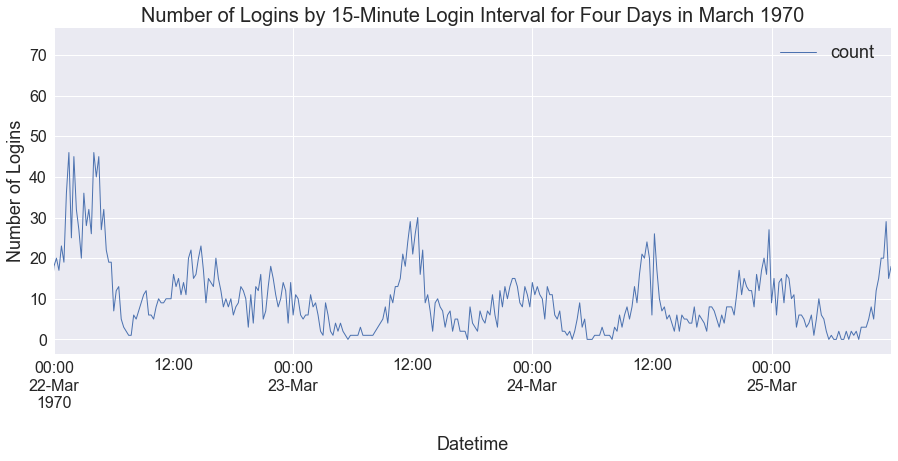

In [14]:
logins15_df.plot(figsize =(15,6), fontsize=16, linewidth=1)
plt.xlim(['1970-03-22 00:00:00','1970-03-25 11:59:59'])
plt.xlabel('\nDatetime', fontsize=18)
plt.ylabel('Number of Logins', fontsize=18)
plt.legend(fontsize=18)
plt.title('Number of Logins by 15-Minute Login Interval for Four Days in March 1970', fontsize=20)
plt.show()

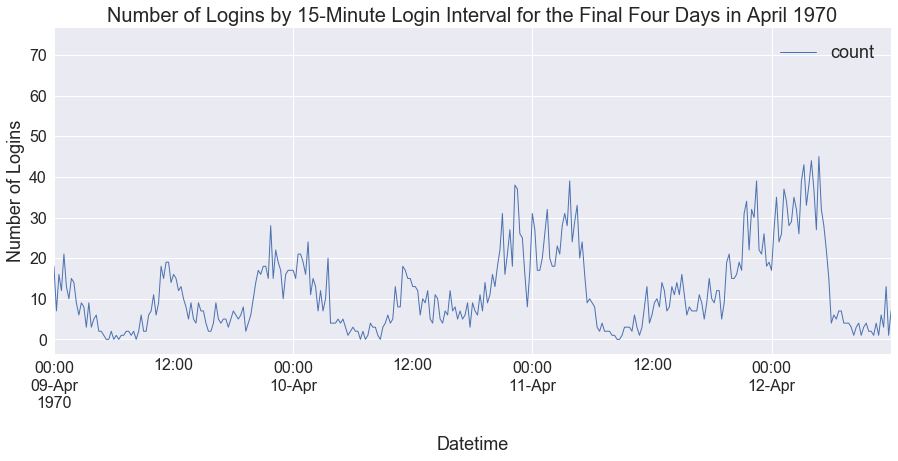

In [15]:
logins15_df.plot(figsize =(15,6), fontsize=16, linewidth=1)
plt.xlim(['1970-04-09 00:00:00','1970-04-12 11:59:59'])
plt.xlabel('\nDatetime', fontsize=18)
plt.ylabel('Number of Logins', fontsize=18)
plt.legend(fontsize=18)
plt.title('Number of Logins by 15-Minute Login Interval for the Final Four Days in April 1970', fontsize=20)
plt.show()

The two plots immediately above show login counts for every 15 minutes for sets of four days, from March 22-25, 1970, and then the final three days (April 9-12, 1970). Logins showed cyclical characteristics during these time spans, with peaks about every 12 hours but with slightly different patterns for each window of time. The two mornings of April 11-12, 1970, showed precipitous drops, though it is not clear why. The dataset ended on April 13, though it is unclear whether the process terminated for some reason at that time, or if there were more data collected after that time.

# Part 2: Gotham/Metropolis

A key measure of success in the Ultimate Gotham/Ultimate Metropolis challenge could be whether there is equivalent allocation of available drivers in both cities (i.e., driver quantities at the same ratio to passenger need or same average distances to passengers in need, reduced number of ride rejections by drivers due to bridge traversal, etc.), and another type of metric could be how much time each driver spends in either city during a period of time (day or night). Each metric could be valid. The question specifically relates to encouragement of drivers to be in both cities. In this vein, a third type of metric could be how much the average driver's daily earnings changes after tolls are removed for them. If I were a city manager I would include all metrics in my analysis, though the first type of metric would be the one serving the most constituents between the two cities. The obvious intent behind the experiment is to ensure passengers are able to get to either city at any time, and drivers are also interested in this goal as it limits their options less. 

If there must be one metric to choose that is specific to assessing the value of this experiment, I would first choose "frequency of ride rejections involving bridge traversal". This is not a long-term metric of ultimate success for the ride service in that region, but it is a metric that relates specifically to the experiment at hand. Another reason for this choice is that a concern I would have with the city managers' plan is that removing tolls, while certainly welcoming to drivers, may not be enough to alleviate the problem. If the bridge itself imparts a traffic bottleneck, for instance, then drivers may feel it is not worth an opportunity loss they may incur by not being able to pick up other fares in that time. Also, reimbursements are never as satisfying as upfront waivers are; if there is any administrative complexity in returning the toll fare to the driver, it likely is not a strong incentivizer for the driver to cross the bridge. The drive itself may be longer than drivers wish to take on a regular basis for other reasons, too. If there is no difference in ride rejections based on crossing the bridge, which would be the null hypothesis for this experiment, then the toll relief has no significant effect. 

Since this is an experiment, for cost purposes it should be treated as a pilot program. There should be a number of drivers sampled from both cities, at a level appropriate for giving statistical analyses the appropriate power (enough drivers for meaningful analyses, but not so many that small signals look significant). It is not clear if there is an imbalance in numbers between the two cities; in any case, the ratio of drivers based in each city should be similar to that of the total driver populations, and they should be randomly sampled. 

There are a number of analyses possible, but I would first establish a baseline rate of bridge-rejections on either side of the bridge, and this could be considered collectively or per-individual with both within-subjects and between-subjects tests, including also a sample population that does not receive toll reimbursements. Also, since we have two populations of drivers, and a binary target characteristic (yes or no for bridge-rejections), we could do before and after chi-squared tests of independence to see if there's any difference between the populations in their tendencies to reject bridge travel. Individual statistical analyses that could be performed include t-tests and bootstrap or permutation tests to test the null hypothesis of no effect versus the alternative hypothesis that reimbursing tolls significantly increases bridge crossings. Each of these tests should be performed. With the way I have structured the target variable (binary rather than continuous, such as, say, average or maximum distances traveled), the effects on this metric based on specific variables would be best examined with logistic regression. There are many variables that could be included in the analysis, but the following would be critical, in my opinion: location where driver is based, length of time of driver's shift(s)(average or total), distance per trip, distance per shift, total ride rejections by driver (including both bridge and non-bridge travel), times of day of trips, perhaps times of day of rejections (to hopefully incorporate traffic).

If the experiment is successful, then the hypothesis tests should all result in a show of an increase in rides across the bridge at a level that reflects statistical significance - could be p<0.05, though for implementation of a plan with potential cost consequences, a stronger show of significance should be considered. Speaking of cost, that is also a metric that should be included for each city, as in how much revenue is lost from the experimental population versus the control population (which may be little if all drivers are simply avoiding the toll bridge as it is). 

# Part 3: Ultimate 

The following project concerns examining which customers continue to use a service into their sixth month since signing up for the service, with consideration of data around the users' habits with the service. The goal is to develop a predictive model to identify what factors contribute to customer retention.

## Data import, cleanup, and initial viewing

In [16]:
#data_df = pd.read_json('./ultimate_data_challenge.json', dtype=dict, orient='records', lines=True)
data = './ultimate_data_challenge.json'
with open(data) as file:
    dict_file = json.load(file)
data_df = pd.DataFrame.from_dict(dict_file, orient='columns')

In [17]:
data_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [18]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [19]:
data_df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [20]:
data_df['last_trip_date'] = pd.to_datetime(data_df['last_trip_date'])
data_df['signup_date'] = pd.to_datetime(data_df['signup_date'])

data_df['days'] = np.nan

data_df['days'] = data_df['last_trip_date'] - data_df['signup_date']

In [21]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
days                      50000 non-null timedelta64[ns]
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2), timedelta64[ns](1)
memory usage: 4.6+ MB


In [22]:
data_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,days
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,143 days
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,96 days
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,1 days
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,170 days
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,47 days


For practical purposes, "into month 6" = 5/12 * 365 + 1 day = 153 days (inclusive of five months plus the first day of the sixth month). This of course may not be accurate to the exact day depending on the exact months included for a user, but it forms a reasonable boundary for our purposes. The target variable for prediction will be for y using (days >= 153).values, with a value of 1 representing a user with 153 or more days for the span between signup_date and last_trip_date, and a 0 for a user with fewer than 153 days for this span. 

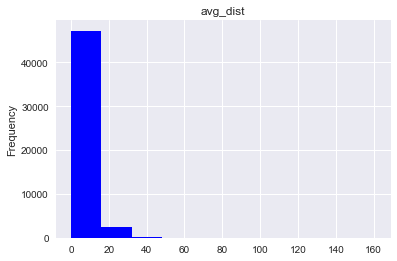

In [23]:
data_df['avg_dist'].plot(kind='hist', color='blue')
plt.title('avg_dist')
plt.show()

Most trips fell within 20 miles.

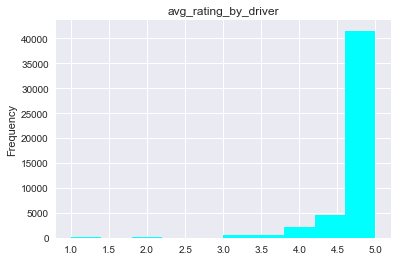

In [24]:
data_df['avg_rating_by_driver'].plot(kind='hist', color='aqua')
plt.title('avg_rating_by_driver')
plt.show()

Drivers tended to give high, if not maximum, ratings to riders.

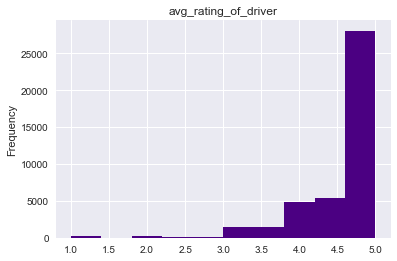

In [25]:
data_df['avg_rating_of_driver'].plot(kind='hist', color='indigo')
plt.title('avg_rating_of_driver')
plt.show()

Riders tended to be generous with ratings of drivers, but there was a relatively higher amount of sub-maximum ratings here than with ratings by drivers.

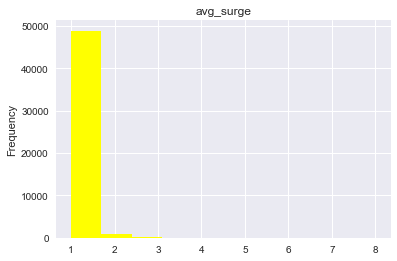

In [26]:
data_df['avg_surge'].plot(kind='hist', color='yellow')
plt.title('avg_surge')
plt.show()

The surge multiplier tended to be 1-2.

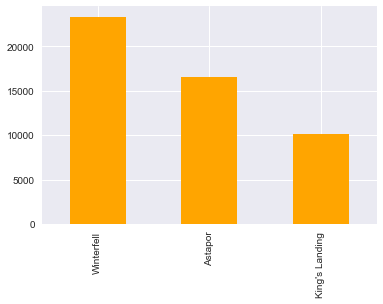

In [27]:
data_df['city'].value_counts().plot(kind='bar', color='orange')
plt.show()

Winterfell ranked first for number of users, though all three had a substantial showing.

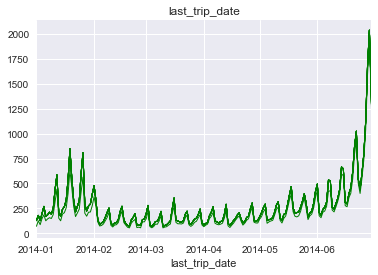

In [28]:
data_df.groupby(data_df['last_trip_date'].dt.date).count().plot(linewidth=1, color='green', legend=None)
plt.title('last_trip_date')
plt.xlim(['2014-01-01', '2014-06-30'])
plt.show()

The last trip date was later, close to the end of the measurement period, for a large amount of users. However, the spikes near the end mask the accumulation of earlier dates among riders throughout the period. 

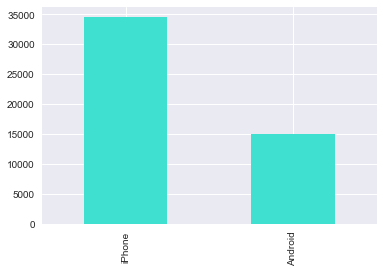

In [29]:
data_df['phone'].value_counts().plot(kind='bar', color='turquoise')
plt.show()

Slightly more than twice as many users used iPhones than Android phones.

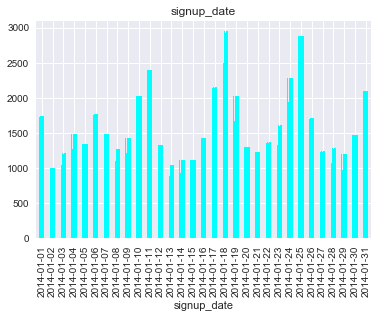

In [30]:
data_df.groupby(data_df['signup_date'].dt.date).count().plot(kind="bar", color='cyan', legend=None)
plt.title('signup_date')
plt.show()

The signup dates were scattered fairly evenly throughout the month, with spikes every week that appear to fall on Saturdays.

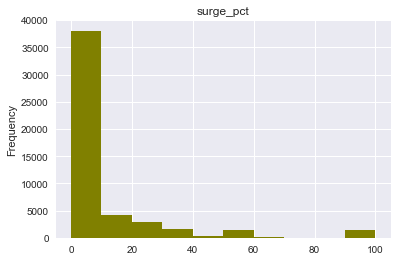

In [31]:
data_df['surge_pct'].plot(kind='hist', color='olive')
plt.title('surge_pct')
plt.show()

Most users had a small percentage of trips that occurred with surge multipliers > 1, though some did have more of their rides during such times. Some had them at around 100% of the time, which could reflect first-timers who then avoided the service.

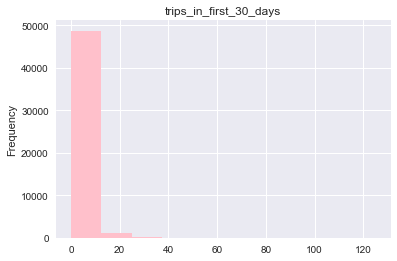

In [32]:
data_df['trips_in_first_30_days'].plot(kind='hist', color='pink')
plt.title('trips_in_first_30_days')
plt.show()

Most people took few trips within their first month of signup.

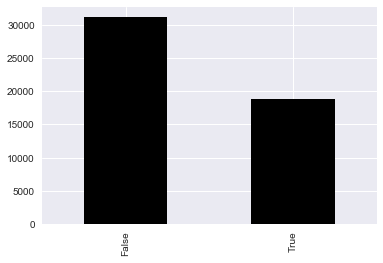

In [33]:
data_df['ultimate_black_user'].value_counts().plot(kind='bar', color='black')
plt.show()

Slightly fewer people were Ultimate Black users than did not use that service.

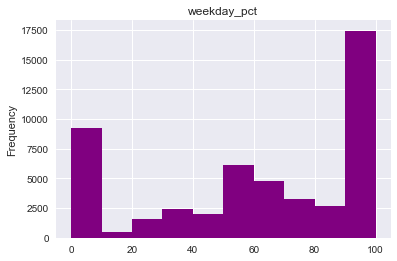

In [34]:
data_df['weekday_pct'].plot(kind='hist', color='purple')
plt.title('weekday_pct')
plt.show()

Usage of the service on weekdays by users was high, though another tail occurred for those who did not use it during weekdays.

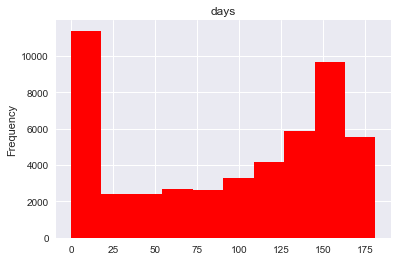

In [35]:
(data_df['days'] / np.timedelta64(1, 'D')).plot(kind='hist', color='red')
plt.title('days')
plt.show()

The days feature, the target that is a composite of signup date subtracted from last trip date, showed a spike around people using the service only briefly. Another spike occurs in the figure around 150 days, with high frequencies for bins around it, indicating a cohort of people with some longevity with the service.

In [36]:
data_df['days']=(data_df['days'] / np.timedelta64(1, 'D'))

In [37]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
days                      50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(7), int64(1), object(2)
memory usage: 4.6+ MB


In [38]:
data_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,days
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,143.0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,96.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,1.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,170.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,47.0


## Exploratory data analysis

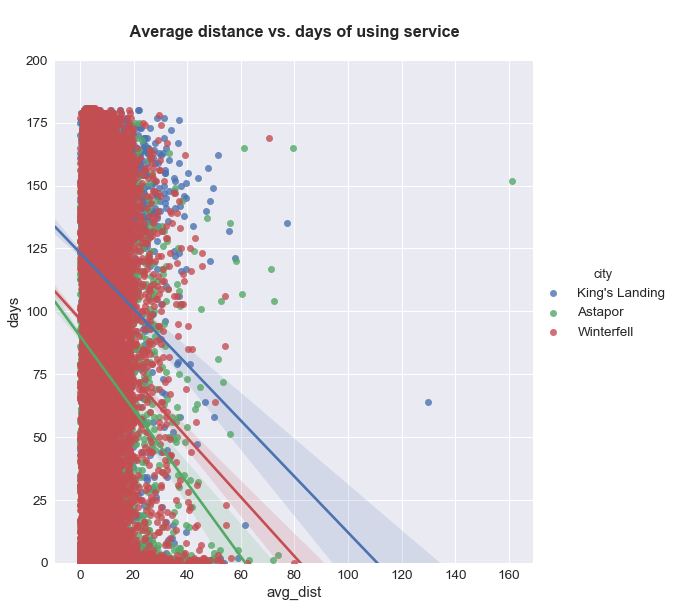

In [39]:
sns.set(font_scale=1.35)
sns.lmplot(x='avg_dist', y='days', data=data_df, hue='city',size=8)
plt.title('\n Average distance vs. days of using service \n', fontweight='bold')

axes = plt.gca()
axes.set_ylim([0,200])

plt.show()

This is a messier chart and not extremely useful, but most of the time people traveled within about 30 miles, regardless of signup city. 

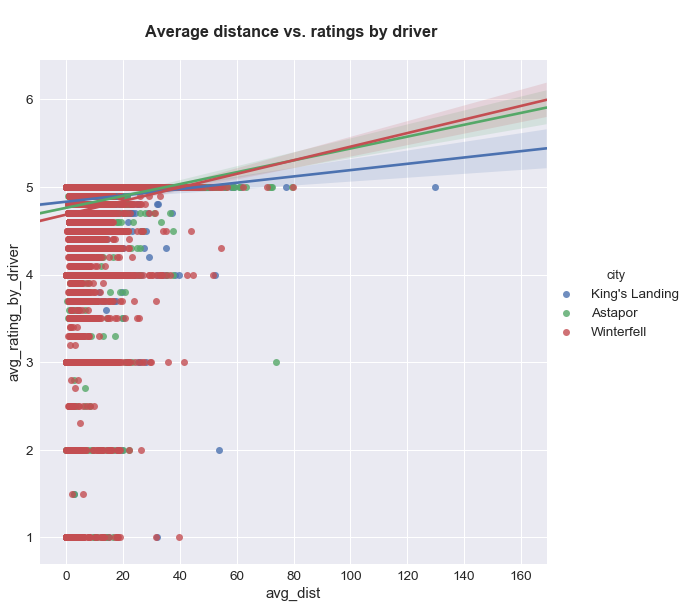

In [40]:
sns.set(font_scale=1.35)
sns.lmplot(x='avg_dist', y='avg_rating_by_driver', data=data_df, hue='city',size=8)
plt.title('\nAverage distance vs. ratings by driver \n', fontweight='bold')
plt.show()

Distance traveled together did not seem to negatively affect ratings drivers gave to riders in any city. 

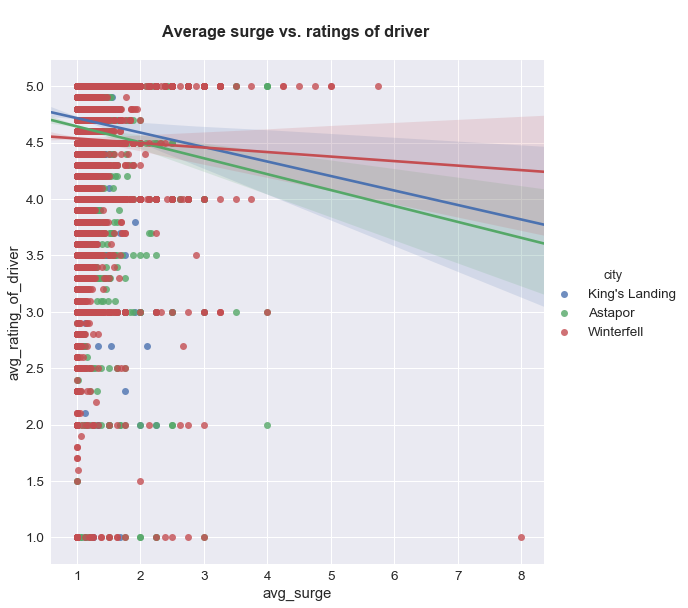

In [41]:
sns.set(font_scale=1.35)
sns.lmplot(x='avg_surge', y='avg_rating_of_driver', data=data_df, hue='city',size=8)
plt.title('\nAverage surge vs. ratings of driver \n', fontweight='bold')
plt.show()

Most people's surge multiplier was 1, but for those rides that were higher than 1, there may be a slight trend, as seen in the trend lines, toward lower ratings of drivers, but the confidence intervals are large, and it is is not an immediately obvious relationship from the figure. 

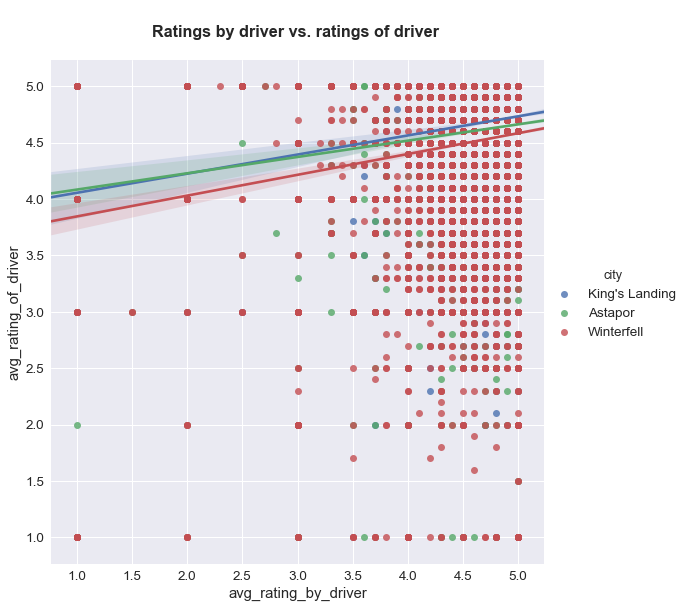

In [42]:
sns.set(font_scale=1.35)
sns.lmplot(x='avg_rating_by_driver', y='avg_rating_of_driver', data=data_df, hue='city',size=8)
plt.title('\nRatings by driver vs. ratings of driver \n', fontweight='bold')
plt.show()

Most drivers and riders were generous in ratings. Drivers in Winterfell had a slight trend toward lower ratings of drivers, but with so many more riders coming from this area it is hard to tell what the reason is. Lower ratings of drivers populate more space on this figure than do lower ratings by drivers.

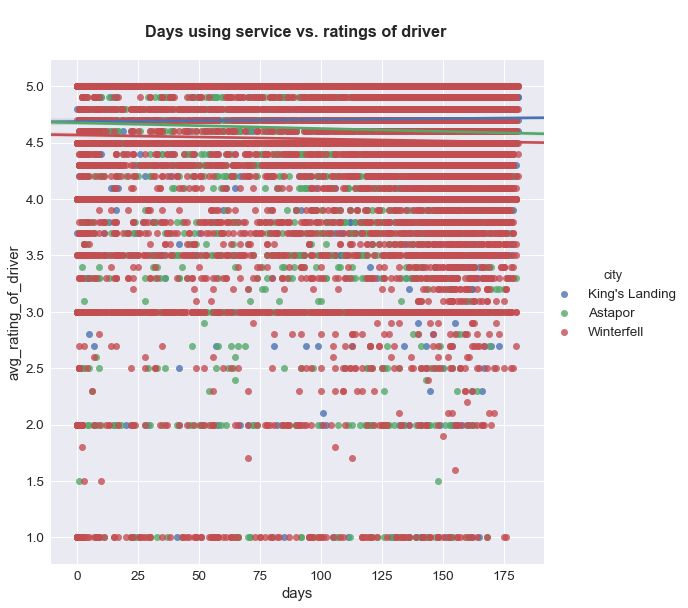

In [43]:
sns.set(font_scale=1.35)
sns.lmplot(x='days', y='avg_rating_of_driver', data=data_df, hue='city',size=8)
plt.title('\nDays using service vs. ratings of driver \n', fontweight='bold')
plt.show()

The trendlines for this figure suggest there was not a strong effect on ratings of drivers based on how many days since a rider had signed up before the ride. The data points themselves are hard to judge this by, as the use of a discrete y-variable here means some data points may be overlapping in different portions of the figure, but the trendlines are more meaningful.


Heatmap of correlations between variables


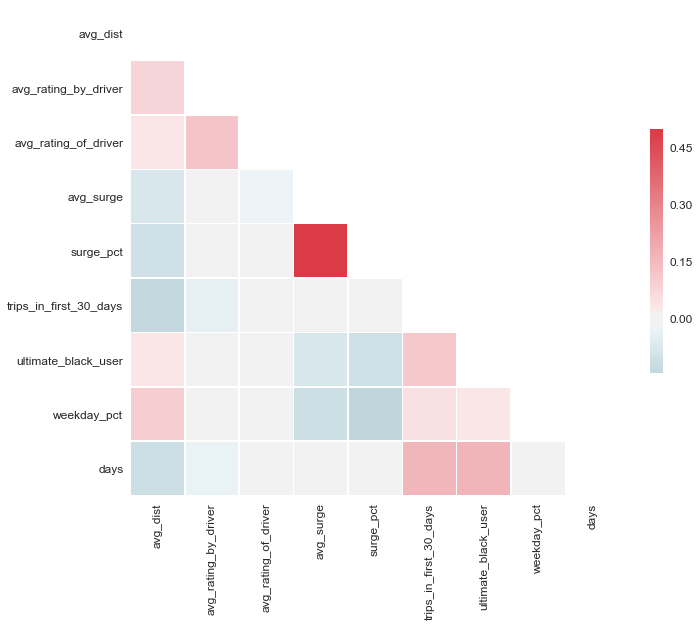

In [44]:
#adapted from code at https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white", font_scale=1.20)
corr = data_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
# mask upper triangle by replacing values with 0 and masking zeros
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
print('\033[1m' + "\nHeatmap of correlations between variables")
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Most features are not very highly correlated with each other here or with the target variable, days. However, the average surge multiplier and percent of trips taken with a surge multiplier >1 are strongly correlated, which is not surprising.

In [45]:
data_df['chi_days'] = (pd.cut(data_df['days'], 8))

def Chi2test(colV, colZ, alpha=0.001):
    V = data_df[colV].astype(str)
    Z = data_df[colZ].astype(str)        
    obs = pd.crosstab(Z,V) 
    chi2, p, dof, expected = stats.chi2_contingency(obs.values)        
    Expected = pd.DataFrame(expected, columns=obs.columns, index = obs.index)
    if p<alpha:
        result="\033[1m {} with {}:".format(colV,colZ)
    else:
        result="\033[0m {} with {}:".format(colV,colZ)
    print(result, f"Chi-square stat. = {round(chi2,2)}, p = {round(p,5)}")
    
print('\033[4m\033[1m\nChi-square statistics and p-values (p) for relationships between categorical variables:\n\033[0m')  
Columns = ['city', 'phone', 'ultimate_black_user', 'chi_days']
for g,h in itertools.combinations(Columns,2):
    Chi2test(g,h) 


Chi-square statistics and p-values (p) for relationships between categorical variables:

 city with phone: Chi-square stat. = 187.85, p = 0.0
 city with ultimate_black_user: Chi-square stat. = 149.87, p = 0.0
 city with chi_days: Chi-square stat. = 3250.75, p = 0.0
 phone with ultimate_black_user: Chi-square stat. = 362.71, p = 0.0
 phone with chi_days: Chi-square stat. = 2353.64, p = 0.0
 ultimate_black_user with chi_days: Chi-square stat. = 1840.32, p = 0.0


Categorical variables here show strong chi-squared relationships. "Chi-days" is a variable included for just this analysis in order to adjust number of days into bins for categorical comparisons. City, phone, usage of Ultimate Black, and number of days with the service are all significantly related according to chi-squared analyses.

In [46]:
data_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,days,chi_days
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,143.0,"(135.75, 158.375]"
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,96.0,"(90.5, 113.125]"
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,1.0,"(-0.181, 22.625]"
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,170.0,"(158.375, 181.0]"
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,47.0,"(45.25, 67.875]"


In [47]:
data_df = data_df.drop('chi_days', axis=1)

In [48]:
#avg_rating_by_driver, avg_rating_of_driver, and phone all have missing data, so will impute now.
#some sklearn classifiers are ok with imputing, but not all are, and it's not clear which classifier is best yet.
#mode will work best for each because they are categoricals with an obviously most common value in each.

In [49]:
avg_rating_by_driver_mode = data_df.avg_rating_by_driver.mode()
data_df['avg_rating_by_driver'] = data_df.avg_rating_by_driver.fillna(avg_rating_by_driver_mode[0])

avg_rating_of_driver_mode = data_df.avg_rating_of_driver.mode()
data_df['avg_rating_of_driver'] = data_df.avg_rating_of_driver.fillna(avg_rating_of_driver_mode[0])

phone_mode = data_df.phone.mode()
data_df['phone'] = data_df.phone.fillna(phone_mode[0])

In [50]:
def pearson(colA, colB, alpha=0.001):
    A = data_df[colA].astype(float)
    B = data_df[colB].astype(float) 
    
    r, p = pearsonr(B,A)
    if p<alpha:
        result="\033[1m {} with {}:".format(colA,colB)
    else:
        result="\033[0m {} with {}:".format(colA,colB)
    print(result, f"Pearson r = {round(r,3)}, p = {round(p,5)}")

print('\033[4m\033[1m\nPearson correlation coefficients (r) and p-values (p) for relationships between continuous variables:\n\033[0m')
cols = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', 
        'ultimate_black_user', 'weekday_pct', 'days']
for e,f in itertools.combinations(cols,2):
    pearson(e,f)


Pearson correlation coefficients (r) and p-values (p) for relationships between continuous variables:

 avg_dist with avg_rating_by_driver: Pearson r = 0.08, p = 0.0
 avg_dist with avg_rating_of_driver: Pearson r = 0.061, p = 0.0
 avg_dist with avg_surge: Pearson r = -0.081, p = 0.0
 avg_dist with surge_pct: Pearson r = -0.104, p = 0.0
 avg_dist with trips_in_first_30_days: Pearson r = -0.136, p = 0.0
 avg_dist with ultimate_black_user: Pearson r = 0.032, p = 0.0
 avg_dist with weekday_pct: Pearson r = 0.102, p = 0.0
 avg_dist with days: Pearson r = -0.109, p = 0.0
 avg_rating_by_driver with avg_rating_of_driver: Pearson r = 0.1, p = 0.0
 avg_rating_by_driver with avg_surge: Pearson r = 0.011, p = 0.01143
 avg_rating_by_driver with surge_pct: Pearson r = 0.021, p = 0.0
 avg_rating_by_driver with trips_in_first_30_days: Pearson r = -0.04, p = 0.0
 avg_rating_by_driver with ultimate_black_user: Pearson r = 0.008, p = 0.05836
 avg_rating_by_driver with weekday_pct: Pearson r = 0.02, p = 

Many relationships among continuous variables, including number of days with the service, show signficancs, even if the Pearson r values are not high. Average distance, for instance, correlates with high ratings both by and of drivers, usage of Ultimate Black, and both weekdays and total days with the service. There are, however, slightly negative relationships between average distance and the surge variables. None of that is surprising (including the fact that people do not want to travel far with the service during surge pricing, most likely). Very few relationships are not statistically signficant overall, at even p<0.05. 

## Preparation for predictive analysis

In [51]:
#Make dummy variables
data_df_dum = pd.get_dummies(data_df)
print(data_df_dum.head())

   avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

  last_trip_date signup_date  surge_pct  trips_in_first_30_days  \
0     2014-06-17  2014-01-25       15.4                       4   
1     2014-05-05  2014-01-29        0.0                       0   
2     2014-01-07  2014-01-06        0.0                       3   
3     2014-06-29  2014-01-10       20.0                       9   
4     2014-03-15  2014-01-27       11.8                      14   

   ultimate_black_user  weekday_pct   days  city_Astapor  city_King's Landing  \
0                 True         46.2  143.0             0                    1   
1             

In [52]:
#sklearn fails with datetime if floats present. Can convert them to integers, but their presence is not helpful anyway,
#as the target variable, days, is already a composite of them.

In [53]:
data_df_dum = data_df_dum.drop(['last_trip_date', 'signup_date'], axis=1)

In [54]:
data_df_dum.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,days,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,3.67,5.0,4.7,1.10,15.4,4,True,46.2,143.0,0,1,0,0,1
1,8.26,5.0,5.0,1.00,0.0,0,False,50.0,96.0,1,0,0,1,0
2,0.77,5.0,4.3,1.00,0.0,3,False,100.0,1.0,1,0,0,0,1
3,2.36,4.9,4.6,1.14,20.0,9,True,80.0,170.0,0,1,0,0,1
4,3.13,4.9,4.4,1.19,11.8,14,False,82.4,47.0,0,0,1,1,0


In [55]:
#(days >= 153).values

X = data_df_dum.drop('days', axis = 1)
y = (data_df_dum.days >= 153).values


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=29, stratify=y)

## Predictive analyses using machine learning

The approach to predictive analysis with this project follows a principle of optimal predictive metrics along with high computational efficiency because this is a project that is designed as a notebook to be transferred among various operators using potentially different systems. Some considerations in that vein include reduced use of packages that may cause incompatibilities with different systems, though operations using the SHAP python package are included at the end of this. At least if there are incompatibilities present with that package, all other portions of this notebook should have been able to run properly beforehand.

The question of which customers will be long-term users of the service, and which features are indicative of this, is a supervised learning problem as we have labels set, and it is a binary classification problem as we are classifying users into one of two target classes based on the span of days between signup and date of last trip.

Classifiers to check include ensemble tree-based methods, boosting methods, logistic regression, and a neural network classifier. Other classifiers, such as support vector machines, may be useful to explore, though for now are ignored as they can take a while to run. First, the models will be run without modifications, and then hyperparameter optimization will occur using only the most promising classifier, as this can take some time to process. The most promising classifier will be judged by a combination of metrics, including: test accuracy, AUC-ROC, F1 score, and precision-recall. It should be noted that the target class is about 77-78% represented by the majority (those not using the service into their sixth month), so any model that is deemed successful should have metrics above that value. 

The target classes in this analysis are slightly imbalanced. The long-term users (>= 153 days) represent 22.4% of samples. This is not a severe imbalance, so it is not yet clear whether accounting for it will be useful. The first step to addressing this was to stratify the train-test sets above to ensure similar representation of classes in each set. Other methods will be discussed further below. 

Accuracy on training data: 0.997
Accuracy on test data: 0.771
             precision    recall  f1-score   support

      False       0.83      0.89      0.86      9701
       True       0.48      0.37      0.42      2799

avg / total       0.75      0.77      0.76     12500

[[8593 1108]
 [1756 1043]]
AUC-ROC score for Extra Trees model: 0.7635


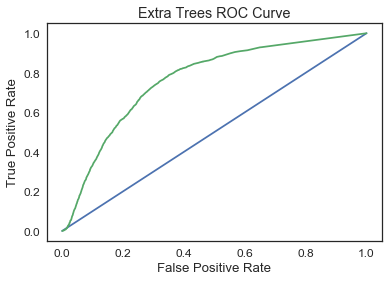

In [56]:
extra = ExtraTreesClassifier(n_estimators=300, class_weight='balanced')
extra.fit(X_train, y_train)

print('Accuracy on training data:',round(extra.score(X_train, y_train),3))
print('Accuracy on test data:',round(extra.score(X_test, y_test),3))
extra_pred = extra.predict(X_test)
print(classification_report(y_test,extra_pred))
print(confusion_matrix(y_test,extra_pred))

ey_pred_prob = extra.predict_proba(X_test)[:,1]
print('AUC-ROC score for Extra Trees model:', round(roc_auc_score(y_test, ey_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, ey_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='Extra Trees Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extra Trees ROC Curve')
plt.show()

Basic Random Forest accuracy on training data: 0.997
Basic Random Forest accuracy on test data: 0.781
             precision    recall  f1-score   support

      False       0.83      0.90      0.86      9701
       True       0.52      0.38      0.44      2799

avg / total       0.76      0.78      0.77     12500

[[8712  989]
 [1746 1053]]
AUC-ROC score for Random Forest model: 0.7768


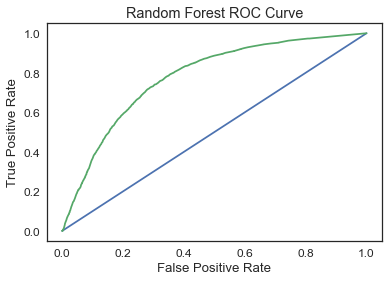

In [57]:
rf = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rf.fit(X_train, y_train)
print('Basic Random Forest accuracy on training data:',round(rf.score(X_train, y_train),3))
print('Basic Random Forest accuracy on test data:',round(rf.score(X_test, y_test),3))
rf_pred = rf.predict(X_test)
print(classification_report(y_test,rf_pred))
print(confusion_matrix(y_test, rf_pred))

ry_pred_prob = rf.predict_proba(X_test)[:,1]
print('AUC-ROC score for Random Forest model:', round(roc_auc_score(y_test, ry_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, ry_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='Random forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()

Accuracy on training data: 0.811
Accuracy on test data: 0.809
             precision    recall  f1-score   support

      False       0.84      0.94      0.88      9701
       True       0.63      0.36      0.46      2799

avg / total       0.79      0.81      0.79     12500

[[9116  585]
 [1798 1001]]
AUC-ROC score for Gradient Boost model: 0.8185


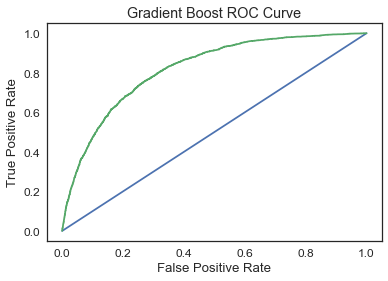

In [58]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gy_pred = gbc.predict(X_test)
print('Accuracy on training data:',round(gbc.score(X_train, y_train),3))
print('Accuracy on test data:',round(gbc.score(X_test, y_test),3))
print(classification_report(y_test,gy_pred))
print(confusion_matrix(y_test,gy_pred))

gy_pred_prob = gbc.predict_proba(X_test)[:,1]
print('AUC-ROC score for Gradient Boost model:', round(roc_auc_score(y_test, gy_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, gy_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='Gradient Boost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boost ROC Curve')
plt.show()

Accuracy on training data: 0.678
Accuracy on test data: 0.683
             precision    recall  f1-score   support

      False       0.87      0.69      0.77      9701
       True       0.38      0.64      0.48      2799

avg / total       0.76      0.68      0.71     12500

[[6733 2968]
 [ 998 1801]]
AUC-ROC score for Logistic Regression model: 0.7299


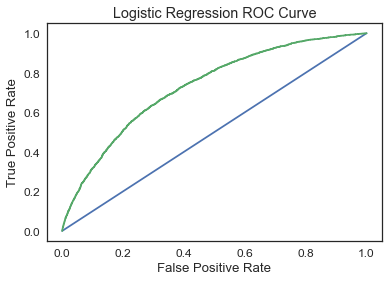

In [59]:
logr = LogisticRegression(class_weight='balanced')
logr.fit(X_train, y_train)
ly_pred = logr.predict(X_test)
print('Accuracy on training data:',round(logr.score(X_train, y_train),3))
print('Accuracy on test data:',round(logr.score(X_test, y_test),3))
print(classification_report(y_test,ly_pred))
print(confusion_matrix(y_test,ly_pred))

ly_pred_prob = logr.predict_proba(X_test)[:,1]
print('AUC-ROC score for Logistic Regression model:', round(roc_auc_score(y_test, ly_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, ly_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

Accuracy on training data: 0.803
Accuracy on test data: 0.803
             precision    recall  f1-score   support

      False       0.83      0.94      0.88      9701
       True       0.61      0.34      0.43      2799

avg / total       0.78      0.80      0.78     12500

[[9093  608]
 [1858  941]]
AUC-ROC score for AdaBoost model: 0.8117


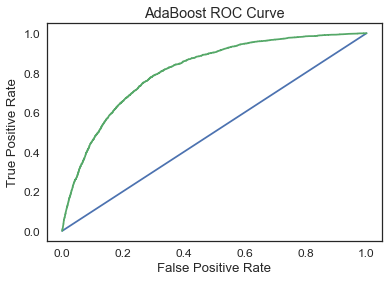

In [60]:
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
ay_pred = abc.predict(X_test)
print('Accuracy on training data:',round(abc.score(X_train, y_train),3))
print('Accuracy on test data:',round(abc.score(X_test, y_test),3))
print(classification_report(y_test,ay_pred))
print(confusion_matrix(y_test,ay_pred))

ay_pred_prob = abc.predict_proba(X_test)[:,1]
print('AUC-ROC score for AdaBoost model:', round(roc_auc_score(y_test, ay_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, ay_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='AdaBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoost ROC Curve')
plt.show()

Accuracy on training data: 0.802
Accuracy on test data: 0.806
             precision    recall  f1-score   support

      False       0.83      0.94      0.88      9701
       True       0.63      0.33      0.43      2799

avg / total       0.78      0.81      0.78     12500

[[9153  548]
 [1881  918]]
AUC-ROC score for MLP model: 0.801


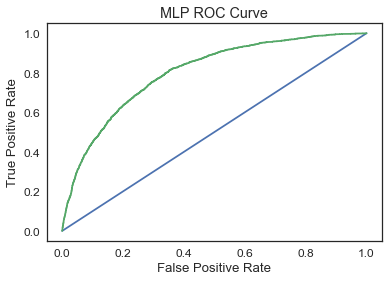

In [61]:
from sklearn.neural_network import MLPClassifier 

mlp = MLPClassifier()
mlp.fit(X_train, y_train)
my_pred = mlp.predict(X_test)
print('Accuracy on training data:',round(mlp.score(X_train, y_train),3))
print('Accuracy on test data:',round(mlp.score(X_test, y_test),3))
print(classification_report(y_test,my_pred))
print(confusion_matrix(y_test,my_pred))

my_pred_prob = mlp.predict_proba(X_test)[:,1]
print('AUC-ROC score for MLP model:', round(roc_auc_score(y_test, my_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, my_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='MLP')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ROC Curve')
plt.show()

Many of the above classifiers produced fairly similar results, with some variation in precision-recall values and overall accuracy or AUC-ROC - still, among these there is a lot of similarity. The most successful models were the two boosting classifiers included in this analysis and the neural network classifier (MLP), though the Gradient Boosting Classifier performed the best overall.

## Hyperparameter tuning on the most promising classifier

In [62]:
gbc_params = {'learning_rate': [0.1, 0.05], 'max_depth': [4, 6, 8],'min_samples_leaf': [20,50]}

CV_gbc = GridSearchCV(estimator=gbc, param_grid=gbc_params, cv=5)
CV_gbc.fit(X_train, y_train)
print(CV_gbc.best_params_)
print(CV_gbc.best_score_)
print(CV_gbc.best_estimator_)

{'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 50}
0.80656
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


In [63]:
gbc_tuned = CV_gbc.best_estimator_
gbc_tuned.fit(X_train, y_train)
gty_pred = gbc_tuned.predict(X_test)
print('Accuracy on training data:',round(gbc_tuned.score(X_train, y_train),3))
print('Accuracy on test data:',round(gbc_tuned.score(X_test, y_test),3))
print(classification_report(y_test,gty_pred))
print(confusion_matrix(y_test,gty_pred))

gty_pred_prob = gbc_tuned.predict_proba(X_test)[:,1]
print('AUC-ROC score for Tuned Gradient Boost model:', round(roc_auc_score(y_test, gty_pred_prob),4))

Accuracy on training data: 0.814
Accuracy on test data: 0.808
             precision    recall  f1-score   support

      False       0.84      0.93      0.88      9701
       True       0.62      0.38      0.47      2799

avg / total       0.79      0.81      0.79     12500

[[9052  649]
 [1746 1053]]
AUC-ROC score for Tuned Gradient Boost model: 0.8185


Since target class is an imbalanced class, it is appropriate to consider an alternate sampling method to apply to the data. For some of the classifiers a class weighting function is already available at the time of analysis, and that has been used where available above. While there are numerous ways of handling this (over-, under-, synthetic sampling, and calibration with sample weights either during model fitting or upon examining probabilities of prediction), after considering some preliminary analyses, the option we will show and emphasize here is random undersampling of the majority class, which equalizes instances of the target class for possible improvement to predictive metrics. Any method of adjusting sampling to deal with imbalanced classes may be worthwhile, but if computational efficiency is important, such as in the presence of a large dataset like this one, resampling by undersampling may provide class balance with more efficient computation than other resampling options do, while also being less prone to overfitting training data than the other methods are. Next here is shown the result of re-running an untuned test with the gradient boosting classifier and then with undersampled training data. Retuning (since that takes a lot of time) is done with undersampled training data if it appears this is useful.

## Addressing imbalance

In [64]:
np.bincount(y_train)

array([29105,  8395])

In [65]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_sample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(False, 8395), (True, 8395)]


Accuracy on training data: 0.749
Accuracy on test data: 0.739
             precision    recall  f1-score   support

      False       0.91      0.74      0.81      9701
       True       0.45      0.75      0.56      2799

avg / total       0.81      0.74      0.76     12500

[[7142 2559]
 [ 703 2096]]
AUC-ROC score for Gradient Boost model: 0.8178


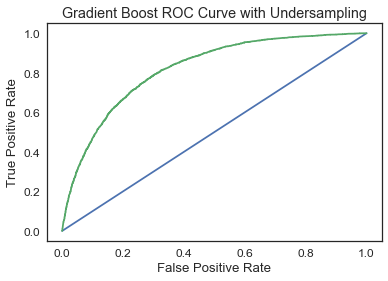

In [66]:
gbcd = GradientBoostingClassifier()
gbcd.fit(X_resampled, y_resampled)
gdy_pred = gbcd.predict(X_test)
print('Accuracy on training data:',round(gbcd.score(X_resampled, y_resampled),3))
print('Accuracy on test data:',round(gbcd.score(X_test, y_test),3))
print(classification_report(y_test,gdy_pred))
print(confusion_matrix(y_test,gdy_pred))

gdy_pred_prob = gbcd.predict_proba(X_test)[:,1]
print('AUC-ROC score for Gradient Boost model:', round(roc_auc_score(y_test, gdy_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, gdy_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='Gradient Boost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boost ROC Curve with Undersampling')
plt.show()

## Choosing the most successful model

The untuned gradient boosting classifier with undersampled training data appeared slightly more successful than without, so next this classifier will be tuned using undersampled training data. 

In [67]:
gbd_params = {'learning_rate': [0.1, 0.05],'max_depth': [4, 6, 8],'min_samples_leaf': [20,50]}

CV_gbcd = GridSearchCV(estimator=gbcd, param_grid=gbd_params, cv=5)
CV_gbcd.fit(X_resampled, y_resampled)
print(CV_gbcd.best_params_)
print(CV_gbcd.best_score_)
print(CV_gbcd.best_estimator_)

{'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 50}
0.7435378201310304
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


In [68]:
gbcd_tuned = CV_gbcd.best_estimator_
gbcd_tuned.fit(X_resampled, y_resampled)
gtdy_pred = gbcd_tuned.predict(X_test)
print('Accuracy on training data:',round(gbcd_tuned.score(X_resampled, y_resampled),3))
print('Accuracy on test data:',round(gbcd_tuned.score(X_test, y_test),3))
print(classification_report(y_test,gtdy_pred))
print(confusion_matrix(y_test,gtdy_pred))

gtdy_pred_prob = gbcd_tuned.predict_proba(X_test)[:,1]
print('AUC-ROC score for Tuned Gradient Boost model:', round(roc_auc_score(y_test, gtdy_pred_prob),4))

Accuracy on training data: 0.782
Accuracy on test data: 0.737
             precision    recall  f1-score   support

      False       0.91      0.73      0.81      9701
       True       0.45      0.75      0.56      2799

avg / total       0.81      0.74      0.76     12500

[[7127 2574]
 [ 710 2089]]
AUC-ROC score for Tuned Gradient Boost model: 0.8179


After retuning and running the gradient boosting classifier with undersampled training data, there was no real improvement owed to undersampling. Accuracy is reduced here, though AUC-ROC is roughly the same as before. F1 score is slightly worse here, though recall is more balanced between the two classes. Also, not shown, SMOTE treatment (another method of dealing with imbalanced classes) had been attempted, but it, too, did not show significant gains in metrics. Factoring in probability of each prediction, not shown, also did not improve predictive power in a way that made sense (producing considerably more false positives). The choice of model to be used, including whether to use undersampling, SMOTE, etc., ultimately would depend on costs associated with each metric. Some results with these methods favor false negatives over false positives, and if the goal of the analysis is identifying clues associated with customers sticking with the service over time, then it is probably more helpful to rely on positives that we are confident about, rather than confuse our expectations with many false positives. (This differs from the sort of analysis in which missing any instances of the positive class is more dangerous, which gives more allowance to false positives rather than false negatives.)

## Feature importance with the chosen gradient boosting model

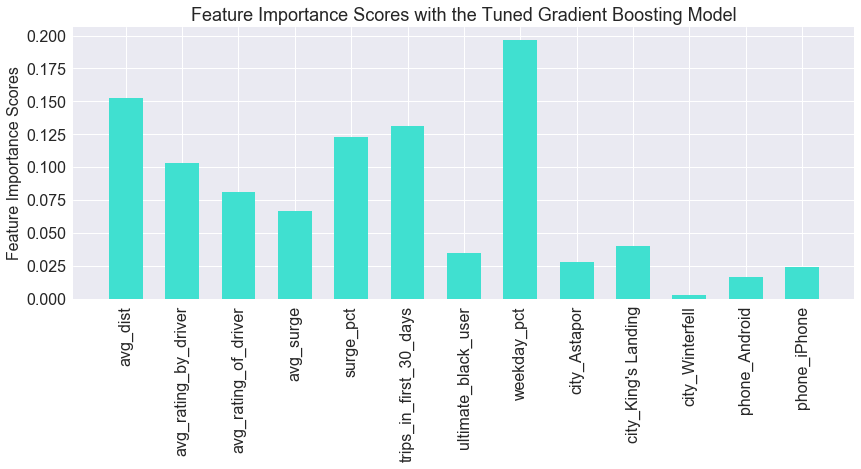

In [69]:
sns.set()
plt.figure(figsize=(14,5))
fi = gbc_tuned.feature_importances_
name = X.columns
plt.bar(np.arange(13),fi, width=0.6, color='turquoise')
plt.xticks(np.arange(13),X[1:],rotation=90, fontsize=16, label = name)
plt.yticks(fontsize=16)
plt.ylabel("Feature Importance Scores", fontsize=16)
plt.title('Feature Importance Scores with the Tuned Gradient Boosting Model', fontsize=18)
plt.show()

With the tuned gradient boosting model, weekday percentage of rides seems to be a strong predictor of a rider's longevity with the service. After weekday percentage, surge percentage is another strong feature here, followed by average distance. Next are average rating by driver, followed by number of trips in first 30 days. Following those features, most other features take on less importance, with phone type and city (apart from King's Landing) taking on the least importance.

## Individual feature importance with SHAP values

The SHAP python package (described at: https://github.com/slundberg/shap) consolidates results of multiple model interpretability metrics, such as LIME and Shapley sampling values, to develop a map of an individual's prediction along with the factors contributing to it. Additionally, summary plots of global predictive values and their contributions can be generated this way. The following shows results of two correct individual predictions and one incorrect one, using this technique and with a subsample (n=100) of the full test dataset, with the predictive model derived from kmeans summarization of training data for ease of computation.

Using the SHAP python package it is possible to get an individual feature map of the model target prediction plus the features and their values that contribute to the prediction. Any features pointing to the right are driving the prediction toward "True" status, or a user without longevity into the sixth month, and vice versa for those pointing to the left.

For sample with index 25 from the test set (from the plot above with output value on the vertical axis and original sample ordering along the horizontal axis), the SHAP target prediction has a value of 1.07. The scale is relative to the dataset, so this is contrasted with the prediction for sample index 42 in the next plot, which has a prediction of 0. 44. What this means is that someone who is likely to hold a "True" value for being a user within the sixth month has a higher SHAP value, and vice versa. For these two individuals the model predicted accurately. However, this model does make some mistaken predictions. Examining multiple samples for SHAP values can sometimes illuminate which features may be problematic, always contributing to a confusing result. 

Sample 25 reflects an Ultimate Black user who has a high percentage of weekday usage of the service, and having a surge percentage of 4.1% was regarded as important to predicting long-term usage by this customer. The user's long average distance of 9.34 miles held the model back from making a stronger prediction of "True" for the target here.

Sample 42 travels a shorter average distance and has a weekday percentage over 50%, which both drive the prediction toward "True" for the target, but a number of features overwhelmingly trend the prediction toward "False"; however, it is not immediately evident from this small sampling why each feature corresponds in this way. Average rating by driver, for instance, is often 5 for many riders, but the classifier has to make a decision. However, here it shows up as having high importance, but perhaps this is considered by the model in conjunction with other features. We will consider effects of each feature below. 

Sample 0 shows where a discrepancy between true value and predictive value occurs (sample was "True" but not identified as such). The SHAP predictive score is in the middle here. An advantage to considering examples like this is that understanding where a model fails can reveal a lot of information about strengths of a dataset.

In [70]:
import shap
shap.initjs() 
ksample = shap.kmeans(X_train, 500)

In [71]:
explainer = shap.KernelExplainer(gbc_tuned.predict_proba, ksample)
shap_values = explainer.shap_values(X_test.iloc[0:99], nsamples=100)

Using 500 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|██████████| 99/99 [01:24<00:00,  1.17it/s]


In [72]:
shap.force_plot(explainer.expected_value[0], shap_values[1][25,:], X_test.iloc[25,:])

In [73]:
shap.force_plot(explainer.expected_value[0], shap_values[1][42,:], X_test.iloc[42,:])

In [74]:
shap.force_plot(explainer.expected_value[0], shap_values[1][0,:], X_test.iloc[0,:])

In [75]:
y_test[25]

True

In [76]:
y_test[42]

False

In [77]:
#For reference
gbctIndiv_pred = gbc_tuned.predict(X_test)
print(list(zip(y_test,gbctIndiv_pred))[0:49])

[(True, False), (True, False), (False, False), (False, False), (True, True), (True, False), (True, True), (False, False), (False, False), (True, False), (False, False), (True, True), (False, False), (False, False), (False, False), (True, False), (False, False), (True, True), (False, False), (False, False), (True, False), (False, False), (False, False), (False, False), (False, False), (True, True), (False, False), (False, False), (True, True), (False, False), (False, False), (False, False), (True, False), (False, False), (False, False), (False, False), (True, False), (False, False), (False, False), (False, False), (False, True), (False, False), (False, False), (False, False), (False, False), (False, False), (True, True), (False, False), (False, False)]


In [78]:
shap.force_plot(explainer.expected_value[0], shap_values[1], X_test.iloc[0:99])

The figure above is best viewed interactively in a web browser because it incorporates a hover tool that allows the user to quickly examine the dominant features and model output scores for each individual in the dataset, in addition to allowing a collective view of the dataset. It is also helpful to set the horizontal view to "original sample ordering", rather than the default display of "sample order by similarity" if wishing to view results for specific index values. The vertical axis provides a default "output value" to give the overall prediction score for each but also provides options for effects on output by feature. Most individuals here show up as being predicted as "False" for longevity into the sixth month, but upward signals correspond to those with "True" predictions. For this view of the data and for the summary plot below, the test dataset was sliced due to the computational time required for analyses. The first 100 samples of the test set are examined to provide a subset of information.

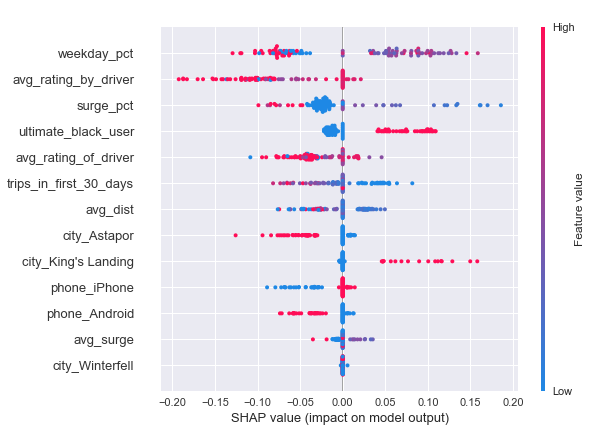

In [79]:
shap.summary_plot(shap_values[1], X_test.iloc[0:99])

The summary plot above shows SHAP values and relative feature values for each individual among the 100 examined here. The higher on the list a feature's position appears at, the more important the feature is considered to be by this method. Any point to the right of the plot corresponds to a prediction of "True" for each feature, and vice versa for those on the left side. Values colored red refer to high values for the feature in question, and vice versa for blue. Due to the massive size of the dataset (for my computer's purposes), the allocation of values here is based on a training set that was derived through K-weighted means, so this could be a source of error. Since this is a very small subset of the overall dataset, it is expected that bias may be present here. Some patterns in the summary plot may be different with the full dataset. 

One thing that immediately appears odd in the plot above is that the average rating by driver is ranked very high, with values showing a great range of effects on SHAP value, but practically all values for that feature correspond to a "False" prediction. This would suggest more sampling is needed to fully develop this analysis, and a similar pattern appears also with average ratings of drivers. This dataset in the summary plot also is a subset of the full test set, showing results for the first 100 samples of the test set, so what appears here could also be a function of how samples are arranged in the overall dataset, with a different slice showing different feature and SHAP values. 

At the top of the chart, weekday percentage shows a mix of results, though relatively medium values (purple) correspond with a prediction of "True" for rider longevity. It could be that rarely using the service on the weekday (compared with weekends) corresponds with riders preferring another way to get to work, while relying upon the service more during the weekdays compels many users to find another way (perhaps is too expensive for very long). There are some individuals predicted to stay with the service who show high or low weekday percentages, but the extremes show up relatively more with predictions of not sticking with the service here. 

Being an Ultimate Black user corresponds with rider longevity, and fewer trips in the first 30 days does as well. Signing up in Astapor corresponds with not sticking with the service into the sixth month, while King's Landing has the opposite effect, and Winterfell does not matter as much. Average distance shows a complex pattern. Android use corresponds with not sticking with the service, while iPhone use has the opposite relationship. Average surge shows a slight pattern in which a low value here corresponds to not sticking with the service, while medium to high values correspond with longevity with the service. It is a weak signal either way for that feature, though. 

## Conclusion

For predicting which users will show longevity with the riding service into the sixth month using this dataset, multiple machine learning models give similar results, but the gradient boosting classifier, applied to the basic dataset (not resampled), seemed to perform the best for the most metrics, with the tuned model giving an accuracy of 0.81, and AUC-ROC of 0.8185, an F1 score of 0.79, and relatively decent precision and recall for the minority class compared with other models, but emphasizing precision for the minority class rather than recall. 

One thing that was not addressed above was outliers. Overall among histograms, even though some x-axes have long scales, there does not appear to be a large amount of obvious outliers. For some variables that have obvious points out of the norm, these plausibly reflect realistic data. It could be useful to remove some possible outliers to enhance model accuracy metrics, but for a first pass I am not inclined to remove data that appear likely real.

It is possible using a model interpretability package to examine the individual factors contributing to one sample's prediction values. This is illuminating for figuring out what matters on an individual basis and providing a way to judge predictions. From these analyses it appears that riders with a medium level of weekday percentage of use of the service, relative to others, show longevity with the service, as does a low surge percentage rate, positive use of Ultimate Black, fewer trips in 30 days, and signing up in King's Landing. 

Weekday percentage appeared to be the top feature, and the pattern here suggests that many riders who use the service either too much during the week (perhaps relative to weekend use) or not enough do not experience sufficient relative value with the service to remain with it. Frequency of trips in a time period of 30 days could also correspond with cost-benefit analyses by customers. Low surge percentage rate along with use of Ultimate Black may indicate riders who are optimizing value with the service according to their needs. Sticking with the service after signing up in King's Landing (and not in Astapor) could be indicative of either demographics in those locations or disparate allocation of resources in those localities by the Ultimate company. 